In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 
                   'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium',
                   'Total phenols', 'Flavanoids',
                   'Nonflavanoid phenols',
                   'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines',
                   'Proline']
print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

('Class labels', array([1, 2, 3]))


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [2]:
from sklearn.cross_validation import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [3]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

In [4]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [5]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1', C=0.1)
lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

('Training accuracy:', 0.9838709677419355)
('Test accuracy:', 0.98148148148148151)


In [6]:
lr.intercept_

array([-0.38379669, -0.15813589, -0.70042572])

In [7]:
lr.coef_

array([[ 0.28036966,  0.        ,  0.        , -0.02798753,  0.        ,
         0.        ,  0.71007812,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.23606551],
       [-0.64374845, -0.0689889 , -0.05717068,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.92727071,
         0.05960926,  0.        , -0.37097839],
       [ 0.        ,  0.06152261,  0.        ,  0.        ,  0.        ,
         0.        , -0.6360383 ,  0.        ,  0.        ,  0.49808215,
        -0.35826094, -0.57127215,  0.        ]])

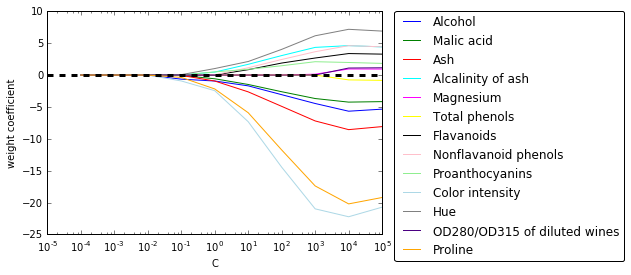

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)

colors = ['blue', 'green', 'red', 'cyan',
          'magenta', 'yellow', 'black',
          'pink', 'lightgreen', 'lightblue',
          'gray', 'indigo', 'orange']

weights, params = [], []
for c in np.arange(-4, 6):
    lr = LogisticRegression(penalty='l1', C=10**c, random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)
weights = np.array(weights)
for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column], label=df_wine.columns[column+1], color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper center', bbox_to_anchor=(1.38, 1.03), ncol=1, fancybox=True)
plt.show()

In [9]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

class SBS():
    def __init__(self, estimator, k_features,
                scoring=accuracy_score,
                test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
    
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                            test_size=self.test_size, 
                                                            random_state=self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]
        
        while dim > self.k_features:
            scores = []
            subsets = []
            
            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                
                scores.append(score)
                subsets.append(p)
            
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        
        return self
    
    def transform(self, X):
        return X[:, self.indices_]
    
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score


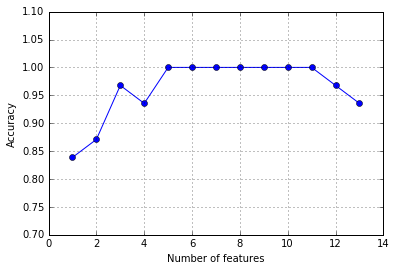

In [10]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
knn = KNeighborsClassifier(n_neighbors=2)
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.show()

In [11]:
k5 = list(sbs.subsets_[8])
print(df_wine.columns[1:][k5])

Index([u'Alcohol', u'Malic acid', u'Alcalinity of ash', u'Hue', u'Proline'], dtype='object')


In [12]:
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))

('Training accuracy:', 0.9838709677419355)


In [13]:
print('Test accuracy:', knn.score(X_test_std, y_test))

('Test accuracy:', 0.94444444444444442)


In [14]:
knn.fit(X_train_std[:, k5], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k5], y_train))

('Training accuracy:', 0.95967741935483875)


In [15]:
print('Test accuracy:', knn.score(X_test_std[:, k5], y_test))

('Test accuracy:', 0.96296296296296291)


In [16]:
from sklearn.ensemble import RandomForestClassifier
feat_labels = df_wine.columns[1:]
forest = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[f], importances[indices[f]]))

 1) Alcohol                        0.182483
 2) Malic acid                     0.158610
 3) Ash                            0.150948
 4) Alcalinity of ash              0.131987
 5) Magnesium                      0.106589
 6) Total phenols                  0.078243
 7) Flavanoids                     0.060718
 8) Nonflavanoid phenols           0.032033
 9) Proanthocyanins                0.025400
10) Color intensity                0.022351
11) Hue                            0.022078
12) OD280/OD315 of diluted wines   0.014645
13) Proline                        0.013916


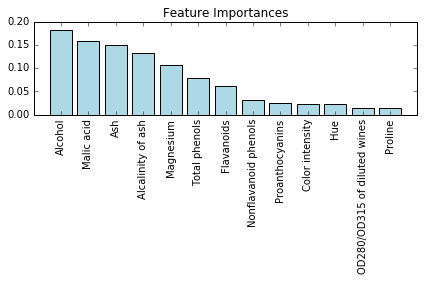

In [17]:
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], color='lightblue', align='center')
plt.xticks(range(X_train.shape[1]), feat_labels, rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()